# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), 

**Required Libraries -** The following R libraries are referenced in this notebook
* glmnet
* ROCR
---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

[3. XGBoost](#3.-XGBoost)

[4. Random Forest](#4.-Random-Forest)

---

In [180]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)
seed=123

In [181]:
# install packages ggplot2 for more fancier plots and graphs
# and psych for a more comprehensive stats package
# only install if not already installed
list.of.packages <- c("ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret", "xgboost", "Matrix", "Ckmeans.1d.dp", 
                     "randomForest", "caretEnsemble", "MASS", "DMwR", "ROSE", "plyr")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org")

In [182]:
# import ggplot for some of the more fancier plots if needed
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")
library("caretEnsemble")
library("MASS")

library("xgboost")
library("Matrix")
library("Ckmeans.1d.dp")
library("randomForest")
library("DMwR")
library("ROSE")
library("plyr")

In [183]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [184]:
prostate <- read.csv("./prostate.csv")

In [185]:
# Before we do anything, dedicate 20% of our data to an unseen Test set.

# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

set.seed(seed)
train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

In [186]:
# Check the head of the dataframe
head(train)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
863,863,5,8,10,9,2,2,8,6,2,3,0
2365,2365,4,4,2,4,4,1,3,7,3,9,0
1227,1227,7,4,9,2,4,2,3,9,9,8,0
2647,2647,5,5,7,2,4,1,8,10,1,7,3
2818,2818,10,1,2,5,7,2,8,5,9,5,1
137,137,8,1,2,10,10,2,2,3,1,5,0


In [187]:
# Check structure of the datatypes
str(train)

'data.frame':	2400 obs. of  12 variables:
 $ ID    : int  863 2365 1227 2647 2818 137 1582 2672 1650 1366 ...
 $ ATT1  : int  5 4 7 5 10 8 7 2 2 5 ...
 $ ATT2  : int  8 4 4 5 1 1 1 10 1 4 ...
 $ ATT3  : int  10 2 9 7 2 2 5 5 6 10 ...
 $ ATT4  : int  9 4 2 2 5 10 4 8 2 7 ...
 $ ATT5  : int  2 4 4 4 7 10 8 5 8 10 ...
 $ ATT6  : int  2 1 2 1 2 2 1 4 2 10 ...
 $ ATT7  : int  8 3 3 8 8 2 9 2 3 3 ...
 $ ATT8  : int  6 7 9 10 5 3 2 6 4 8 ...
 $ ATT9  : int  2 3 9 1 9 1 6 1 1 10 ...
 $ ATT10 : int  3 9 8 7 5 5 7 3 4 2 ...
 $ Result: int  0 0 0 3 1 0 0 2 2 1 ...


We can drop the ID column as it adds no benefit to our modelling

In [188]:
train$ID <- NULL

Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [189]:
train$Result <- as.factor(train$Result) 

In [190]:
# Let's check for incomplete observations
nrow(train[complete.cases(train),])

[1] 2400

In [191]:
# Check the proportions of each factor within the Result variable in our train set
print(table(train$Result))


  0   1   2   3 
868 876 495 161 


In [192]:
# Check the proportions of each factor within the Result variable in our test set
print(table(test$Result))


  0   1   2   3 
214 204 147  35 


We have class imbalance. This will need to be addressed when training our models, potentially with some sampling techniques. 

In [193]:
round(describe(train), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ATT1,1.000,2400.000,5.835,2.651,6.000,5.793,2.965,2.000,10.000,8.000,0.098,-1.160,0.054
ATT2,2.000,2400.000,4.510,2.736,4.000,4.327,2.965,1.000,10.000,9.000,0.401,-0.972,0.056
ATT3,3.000,2400.000,5.865,2.675,6.000,5.831,2.965,2.000,10.000,8.000,0.090,-1.189,0.055
ATT4,4.000,2400.000,5.807,2.630,6.000,5.759,2.965,2.000,10.000,8.000,0.090,-1.154,0.054
ATT5,5.000,2400.000,5.767,2.631,6.000,5.708,2.965,2.000,10.000,8.000,0.111,-1.144,0.054
ATT6,6.000,2400.000,4.450,2.699,4.000,4.264,2.965,1.000,10.000,9.000,0.433,-0.947,0.055
ATT7,7.000,2400.000,4.474,2.739,4.000,4.290,2.965,1.000,10.000,9.000,0.399,-1.026,0.056
ATT8,8.000,2400.000,4.499,2.729,4.000,4.317,2.965,1.000,10.000,9.000,0.386,-0.978,0.056
ATT9,9.000,2400.000,4.484,2.688,4.000,4.299,2.965,1.000,10.000,9.000,0.412,-0.918,0.055
ATT10,10.000,2400.000,4.451,2.689,4.000,4.263,2.965,1.000,10.000,9.000,0.412,-0.935,0.055


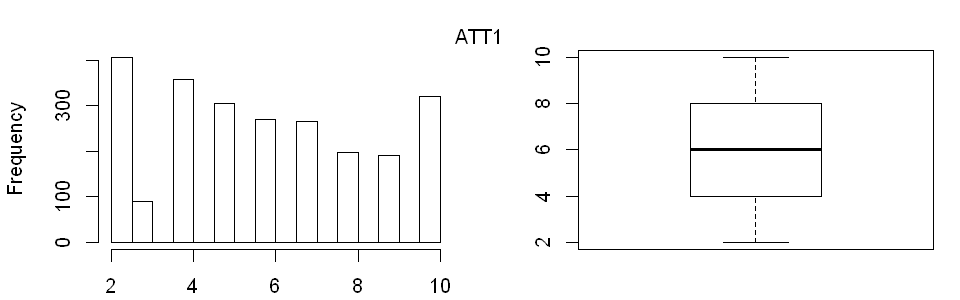

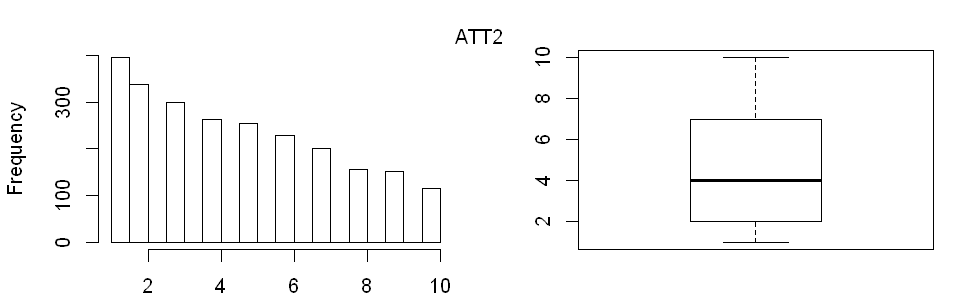

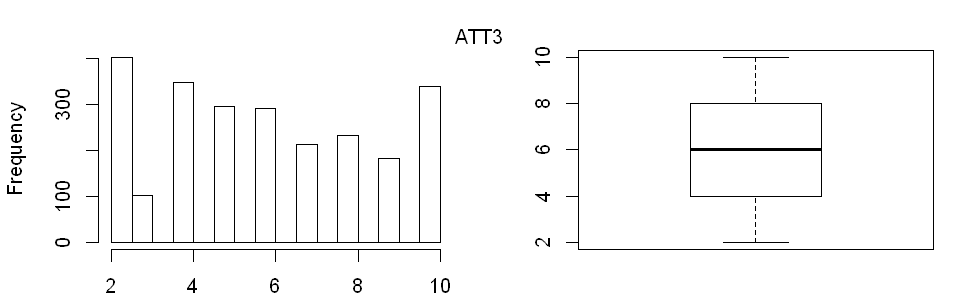

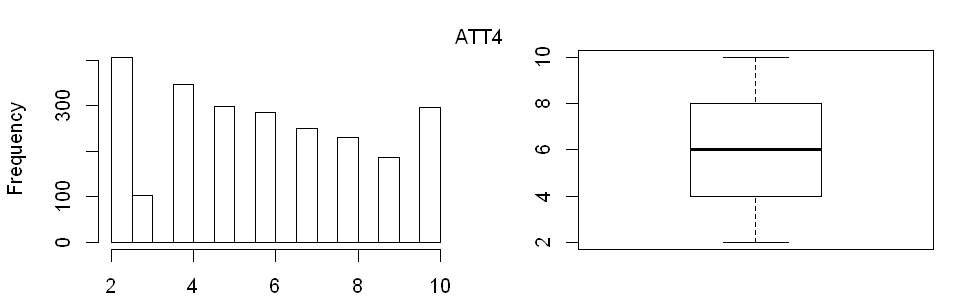

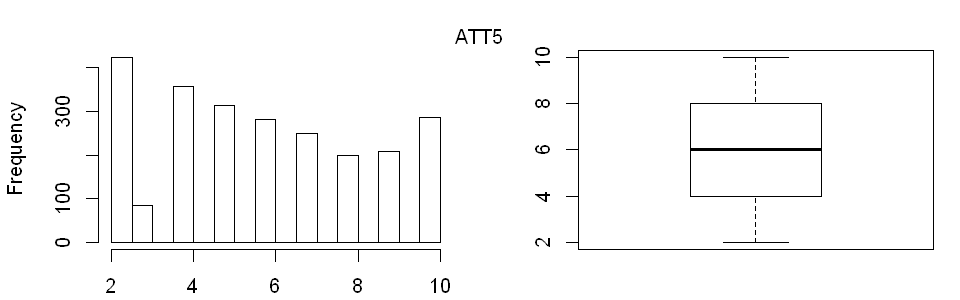

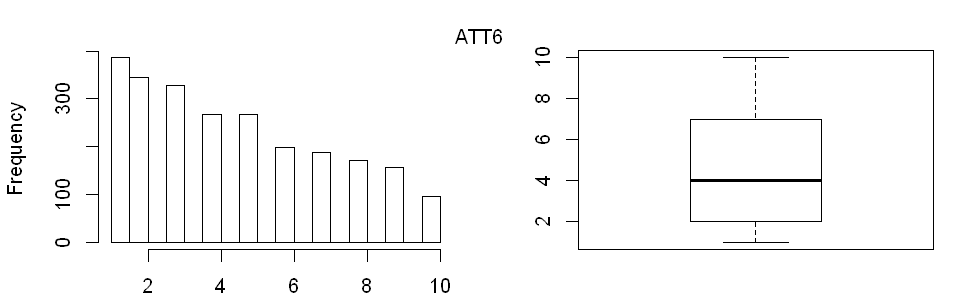

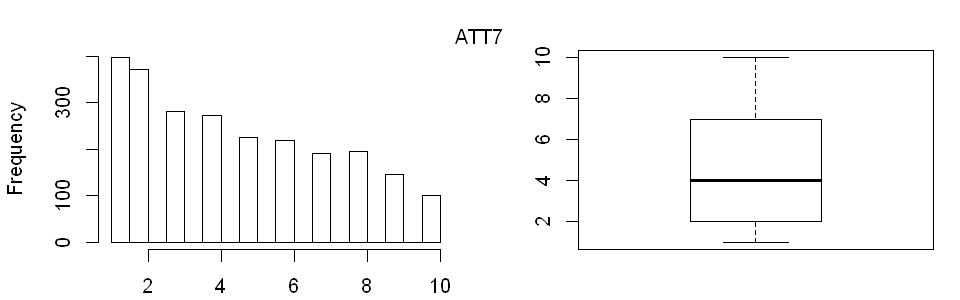

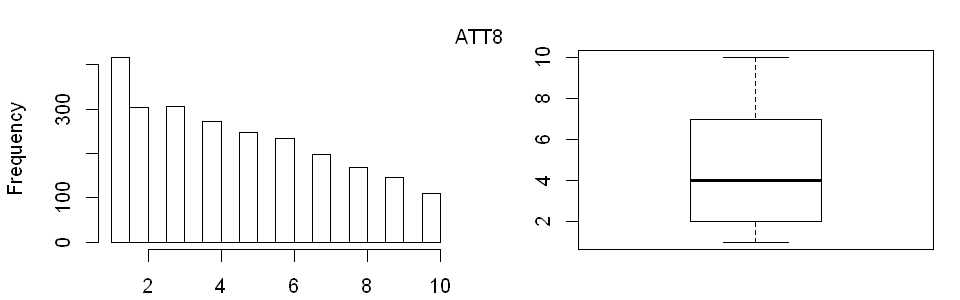

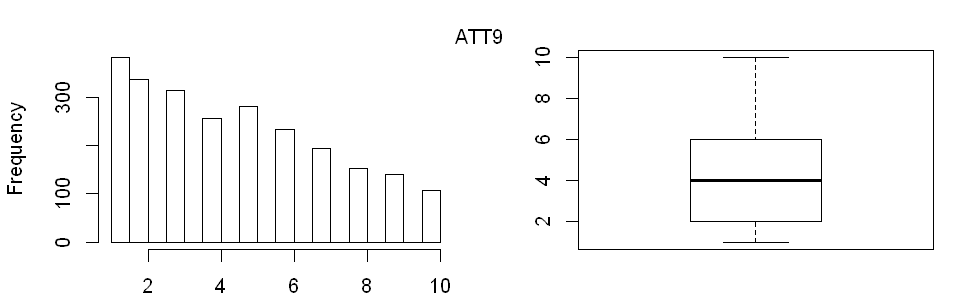

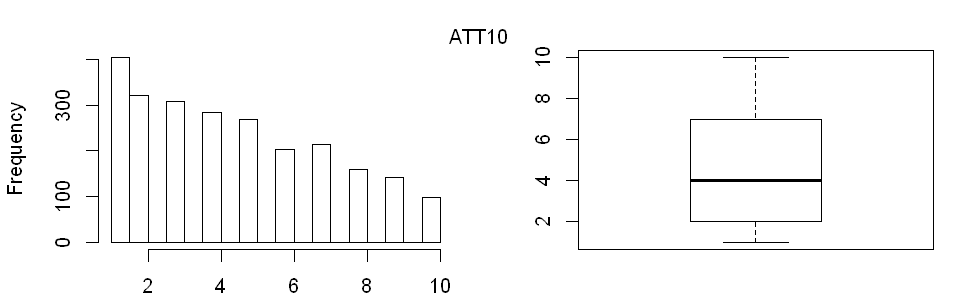

In [194]:
oldpar <- par() #this records all the default settings
par(mfrow=c(1,2)) # this makes to plots in one row
par(mar=c(2.1,4.1,2.1,1.1)) #BLTR
options(repr.plot.width=8, repr.plot.height=2.5)
for (i in names(train)) {
    if (i != "Result") {
        hist(train[[i]],xlab=NULL,main=NULL)
        boxplot(train[[i]])
        mtext(i,side=3,line=-2, outer=TRUE)
    }
}
suppressWarnings( par(oldpar)) # Restore settings

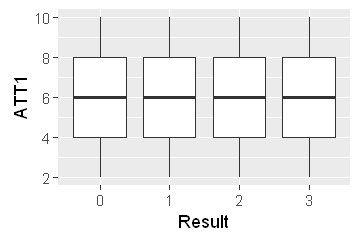

In [195]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
ggplot(train, aes(x = Result, y = ATT1)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT2)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT3)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT4)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT5)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT6)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT7)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT8)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT9)) + geom_boxplot()
#ggplot(train, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

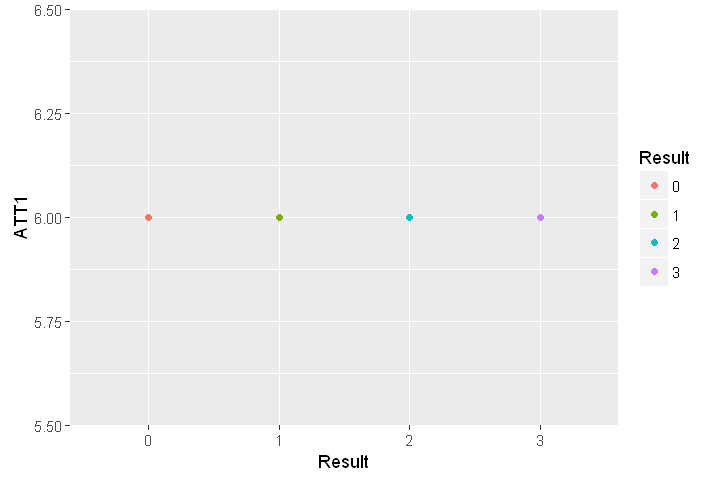

In [196]:
ggplot(aes(x=Result, y=ATT1, color=Result),  #by setting color=color, ggplot automatically draw in different colors
       data=train) + geom_point(stat='summary', fun.y=median)

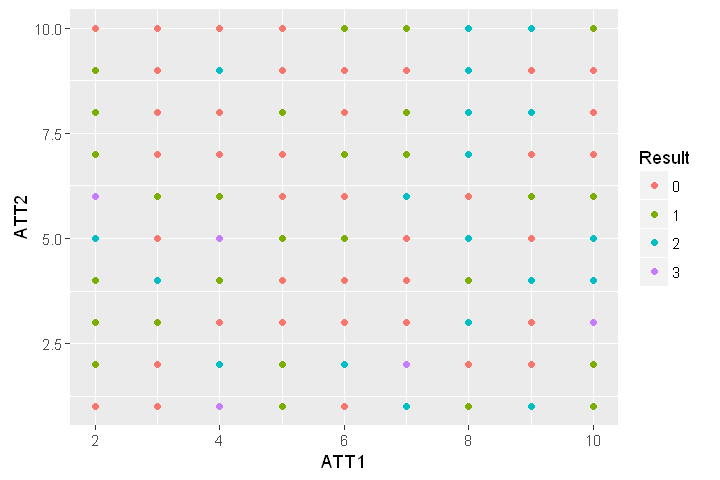

In [197]:
qplot(ATT1, ATT2, colour=Result, data=train)

# 2. EDA Report

Perform an EDA, and prepare a summary of your findings. The summary should be less than 300 words. You need to emphasise on the aspects of the EDA that guide you in choosing a particular model or algorithm for your classifier. If you want to include any chart in your notebook, there should be something you have learnt and you are going to use it in your model selection. Please provide a short explanation on what you have learnt just after the cell. In addition, types of variables, the dimension of the data, and any correlation between variables are very important. Also, you might need to look at some distribution of your variables to get some insights.

---
# 3. XGBoost

In [198]:
# perform down sampling to obtain even amount of classes
#xg_train <- Udf.Utilities.DownSample(train)
xg_train <- Udf.Utilities.UpSample(train)
#xg_train <- Udf.Utilities.SmoteSample(train)

xg_test <- test

In [199]:
# Check the proportions of each factor within the Result variable
w <- table(xg_train$Result)
w


  0   1   2   3 
876 876 876 876 

In [200]:
# store the actuals for future comparison
actual <- test$Result

In [201]:
# set the Result to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [202]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [203]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [204]:
watchlist <- list(xg_train=dtrain)

In [205]:
# cross validate to select optimal value for number of rounds
set.seed(seed)
n_rounds.cv <- 500
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = 6, eta = 0.1,
               colsample_bytree = 0.9, subsample = 0.9)

bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.508879+0.012468	test-merror:0.624680+0.024307
[20]	train-merror:0.176560+0.008523	test-merror:0.468025+0.029982
[40]	train-merror:0.100583+0.002541	test-merror:0.418943+0.031163
[60]	train-merror:0.061802+0.002610	test-merror:0.406106+0.027163
[80]	train-merror:0.036307+0.002331	test-merror:0.396708+0.024365
[100]	train-merror:0.021911+0.001830	test-merror:0.384998+0.024580
[120]	train-merror:0.013667+0.001957	test-merror:0.381288+0.025276
[140]	train-merror:0.007325+0.001342	test-merror:0.372162+0.028310
[160]	train-merror:0.004027+0.000748	test-merror:0.369870+0.031357
[180]	train-merror:0.002030+0.000477	test-merror:0.369019+0.029462
[200]	train-merror:0.001237+0.000484	test-merror:0.369307+0.028689
[220]	train-merror:0.000634+0.000473	test-merror:0.369020+0.025303
[240]	train-merror:0.000190+0.000401	test-merror:0.368169+0.024413
[260]	train-merror:0.000000+0.000000	test-merror:0.367882+0.024541
[280]	train-merror:0.000000+0.000000	test-merror:0.366731+0.021838
[

In [206]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 306

In [207]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.481735
[1]	xg_train-merror:0.431221
[2]	xg_train-merror:0.384132
[3]	xg_train-merror:0.363870
[4]	xg_train-merror:0.333048
[5]	xg_train-merror:0.309075
[6]	xg_train-merror:0.301941
[7]	xg_train-merror:0.283390
[8]	xg_train-merror:0.272260
[9]	xg_train-merror:0.261701
[10]	xg_train-merror:0.253995
[11]	xg_train-merror:0.251142
[12]	xg_train-merror:0.242295
[13]	xg_train-merror:0.227740
[14]	xg_train-merror:0.218893
[15]	xg_train-merror:0.213756
[16]	xg_train-merror:0.204053
[17]	xg_train-merror:0.196062
[18]	xg_train-merror:0.192922
[19]	xg_train-merror:0.194064
[20]	xg_train-merror:0.183505
[21]	xg_train-merror:0.178368
[22]	xg_train-merror:0.175799
[23]	xg_train-merror:0.167808
[24]	xg_train-merror:0.160674
[25]	xg_train-merror:0.162671
[26]	xg_train-merror:0.154110
[27]	xg_train-merror:0.150685
[28]	xg_train-merror:0.145263
[29]	xg_train-merror:0.144121
[30]	xg_train-merror:0.141838
[31]	xg_train-merror:0.138128
[32]	xg_train-merror:0.136986
[33]	xg_train-merror

In [208]:
# generate predictions from model
pred <- predict(bst, xg_test);

In [209]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 87 74 53 14
         1 96 96 65 15
         2 26 26 19  6
         3  5  8 10  0

Overall Statistics
                                        
               Accuracy : 0.337         
                 95% CI : (0.299, 0.376)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.857         
                                        
                  Kappa : 0.02          
 Mcnemar's Test P-Value : 0.00000254    

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.407    0.471   0.1293   0.0000
Specificity             0.635    0.556   0.8720   0.9593
Pos Pred Value          0.382    0.353   0.2468   0.0000
Neg Pred Value          0.659    0.671   0.7553   0.9393
Prevalence              0.357    0.340   0.2450   0.0583
Detection Rate          0.145    0.160   0.0317   0.0000
Detection Prevalence    0.380    0.453   0.1283   0.0383
Balan

In [210]:
feature.importance <- xgb.importance(dimnames(xg_train)[[2]], model = bst)
head(feature.importance)

,Feature,Gain,Cover,Frequence
1,ATT1,0.10390966550576,0.0981755346404982,0.101203491675419
2,ATT8,0.102791930874813,0.099764665068689,0.104337046538455
3,ATT6,0.102218151576762,0.100768030999155,0.100377059623629
4,ATT9,0.101283366999252,0.119313919615232,0.102408705084279
5,ATT3,0.100779416609292,0.0879046412291317,0.0962276820302681
6,ATT4,0.100654424779475,0.0885402422921847,0.0981904581532687


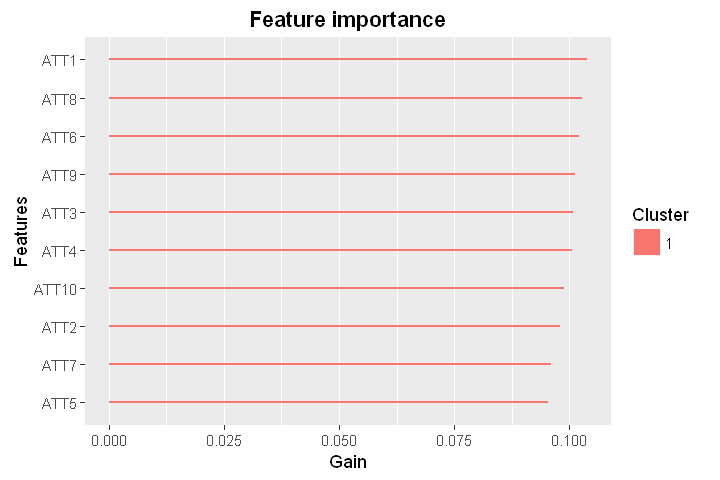

In [211]:
xgb.plot.importance(feature.importance)

## Cross Validate further parameters for XGBoost using GridSearch

In [213]:
xgbGrid <- expand.grid(
    nrounds = c(100, 300, 500),
    max_depth = c(1, 3, 5),
    eta = c(0.001, 0.01, 0.1),
    gamma = c(0, 1),
    colsample_bytree = c(1, 0.9, 0.8),
    min_child_weight = c(1, 2, 3)
)

In [214]:
xgbTrControl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 2,
    verboseIter = FALSE,
    returnData = FALSE,
    allowParallel = TRUE
)

In [215]:
xg_train <- Udf.Utilities.UpSample(train)
xg_train$Result <- as.numeric(xg_train$Result)-1
for(i in c(1:ncol(xg_train))) {
    xg_train[,i] <- as.numeric(xg_train[,i])
}

In [216]:
set.seed(seed)

# This is computationaly expensive - takes about an hour
"xgbTrain <- train(
    x = as.matrix(xg_train[, ! names(xg_train) %in% c("Result")]), 
    y = xg_train$Result,
    objective = "multi:softmax",
    trControl = xgbTrControl,
    tuneGrid = xgbGrid,
    method = "xgbTree",
    num_class = 4,
    eval_metric = 'merror'
)
"

In [217]:
# get the top model and its results
head(xgbTrain$results[with(xgbTrain$results, order(RMSE)), ], 5)

,eta,max_depth,gamma,colsample_bytree,min_child_weight,nrounds,RMSE,Rsquared,RMSESD,RsquaredSD
453,0.10000,5.00000,0.00000,1.00000,1.00000,500.00000,0.86904,0.49347,0.02318,0.02404
435,0.10000,5.00000,0.00000,0.80000,1.00000,500.00000,0.87472,0.48725,0.02141,0.02130
444,0.10000,5.00000,0.00000,0.90000,1.00000,500.00000,0.87515,0.48591,0.02974,0.02866
447,0.10000,5.00000,0.00000,0.90000,2.00000,500.00000,0.87788,0.48436,0.02259,0.02233
456,0.10000,5.00000,0.00000,1.00000,2.00000,500.00000,0.88201,0.48026,0.03646,0.03249


In [218]:
# Alter the params based on the best performing set of params abvove
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = 5, eta = 0.1,
               colsample_bytree = 1, subsample = 0.9,
               gamma = 0, min_child_weight = 1)

[0]	xg_train-merror:0.556221
[1]	xg_train-merror:0.497717
[2]	xg_train-merror:0.467180
[3]	xg_train-merror:0.440068
[4]	xg_train-merror:0.414098
[5]	xg_train-merror:0.410103
[6]	xg_train-merror:0.392409
[7]	xg_train-merror:0.379852
[8]	xg_train-merror:0.368436
[9]	xg_train-merror:0.362158
[10]	xg_train-merror:0.359018
[11]	xg_train-merror:0.346176
[12]	xg_train-merror:0.338470
[13]	xg_train-merror:0.335331
[14]	xg_train-merror:0.335046
[15]	xg_train-merror:0.328482
[16]	xg_train-merror:0.323630
[17]	xg_train-merror:0.315639
[18]	xg_train-merror:0.303653
[19]	xg_train-merror:0.297089
[20]	xg_train-merror:0.295377
[21]	xg_train-merror:0.288813
[22]	xg_train-merror:0.283961
[23]	xg_train-merror:0.281963
[24]	xg_train-merror:0.279395
[25]	xg_train-merror:0.273973
[26]	xg_train-merror:0.271690
[27]	xg_train-merror:0.260845
[28]	xg_train-merror:0.258276
[29]	xg_train-merror:0.254281
[30]	xg_train-merror:0.252568
[31]	xg_train-merror:0.248573
[32]	xg_train-merror:0.245148
[33]	xg_train-merror

In [221]:
bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.544806+0.009477	test-merror:0.631576+0.023790
[20]	train-merror:0.286276+0.011618	test-merror:0.502849+0.020008
[40]	train-merror:0.205131+0.007171	test-merror:0.470029+0.020167
[60]	train-merror:0.147419+0.005281	test-merror:0.443201+0.018421
[80]	train-merror:0.112633+0.003977	test-merror:0.433800+0.018688
[100]	train-merror:0.086251+0.004441	test-merror:0.419822+0.025273
[120]	train-merror:0.066432+0.003434	test-merror:0.408693+0.024941
[140]	train-merror:0.051719+0.003224	test-merror:0.404983+0.020098
[160]	train-merror:0.039511+0.002767	test-merror:0.399562+0.018868
[180]	train-merror:0.030473+0.002881	test-merror:0.394987+0.018015
[200]	train-merror:0.023560+0.001465	test-merror:0.385577+0.022492
[220]	train-merror:0.017948+0.001190	test-merror:0.382151+0.024049
[240]	train-merror:0.013001+0.001465	test-merror:0.377873+0.024012
[260]	train-merror:0.009703+0.000936	test-merror:0.372733+0.022339
[280]	train-merror:0.006913+0.000955	test-merror:0.371312+0.024727
[

In [222]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 458

In [223]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.564783
[1]	xg_train-merror:0.498002
[2]	xg_train-merror:0.468607
[3]	xg_train-merror:0.442922
[4]	xg_train-merror:0.428082
[5]	xg_train-merror:0.419521
[6]	xg_train-merror:0.403824
[7]	xg_train-merror:0.390126
[8]	xg_train-merror:0.389555
[9]	xg_train-merror:0.382135
[10]	xg_train-merror:0.362158
[11]	xg_train-merror:0.356164
[12]	xg_train-merror:0.351598
[13]	xg_train-merror:0.341039
[14]	xg_train-merror:0.333333
[15]	xg_train-merror:0.329623
[16]	xg_train-merror:0.325913
[17]	xg_train-merror:0.320491
[18]	xg_train-merror:0.306221
[19]	xg_train-merror:0.305080
[20]	xg_train-merror:0.302797
[21]	xg_train-merror:0.297945
[22]	xg_train-merror:0.287100
[23]	xg_train-merror:0.285103
[24]	xg_train-merror:0.273687
[25]	xg_train-merror:0.275114
[26]	xg_train-merror:0.272546
[27]	xg_train-merror:0.268550
[28]	xg_train-merror:0.260845
[29]	xg_train-merror:0.251142
[30]	xg_train-merror:0.249715
[31]	xg_train-merror:0.247432
[32]	xg_train-merror:0.242009
[33]	xg_train-merror

In [224]:
#xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
# generate predictions from model
pred <- predict(bst, xg_test);

In [225]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 81 70 51 11
         1 96 94 61 17
         2 31 33 29  7
         3  6  7  6  0

Overall Statistics
                                        
               Accuracy : 0.34          
                 95% CI : (0.302, 0.379)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.814354      
                                        
                  Kappa : 0.028         
 Mcnemar's Test P-Value : 0.000795      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.379    0.461   0.1973   0.0000
Specificity             0.658    0.561   0.8433   0.9664
Pos Pred Value          0.380    0.351   0.2900   0.0000
Neg Pred Value          0.656    0.669   0.7640   0.9398
Prevalence              0.357    0.340   0.2450   0.0583
Detection Rate          0.135    0.157   0.0483   0.0000
Detection Prevalence    0.355    0.447   0.1667   0.0317
Balan

# 4. Random Forest

In [84]:
rforest_train <- Udf.Utilities.UpSample(train)
rforest <- randomForest(Result ~., data = rforest_train)

In [85]:
rforest


Call:
 randomForest(formula = Result ~ ., data = rforest_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 35.97%
Confusion matrix:
    0   1   2   3 class.error
0 367 382 116   8      0.5796
1 392 356 110  15      0.5922
2 116 114 640   3      0.2669
3   0   0   0 873      0.0000

In [86]:
pred <- predict(rforest, test)

In [87]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 101  99  55  24
         1  92  89  60  17
         2  13  25  14   5
         3   3   3   0   0

Overall Statistics
                                           
               Accuracy : 0.34             
                 95% CI : (0.302, 0.379)   
    No Information Rate : 0.36             
    P-Value [Acc > NIR] : 0.856            
                                           
                  Kappa : 0.003            
 Mcnemar's Test P-Value : 0.000000000000179

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.483    0.412   0.1085   0.0000
Specificity             0.545    0.560   0.9087   0.9892
Pos Pred Value          0.362    0.345   0.2456   0.0000
Neg Pred Value          0.664    0.629   0.7882   0.9226
Prevalence              0.348    0.360   0.2150   0.0767
Detection Rate          0.168    0.148   0.0233   0.0000
Detection Prevalen

In [88]:
print(importance(rforest,type = 2))

      MeanDecreaseGini
ATT1             244.7
ATT2             278.2
ATT3             260.4
ATT4             255.3
ATT5             255.6
ATT6             261.5
ATT7             270.8
ATT8             241.1
ATT9             275.7
ATT10            267.1


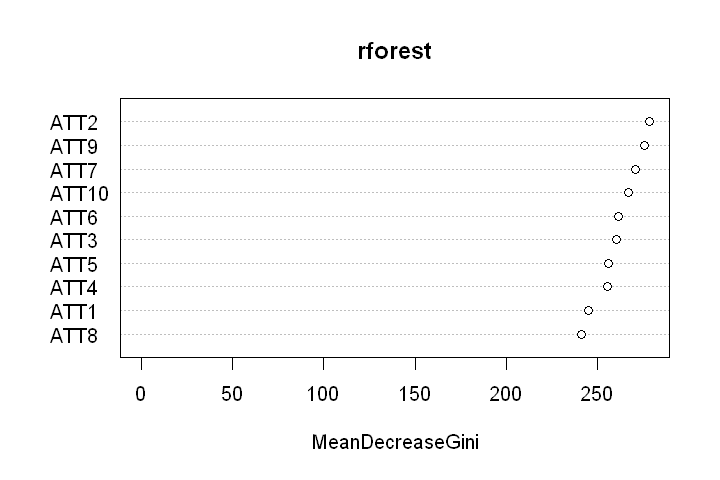

In [91]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
varImpPlot(rforest)

## Cross Validation for Random Forest feature selection 

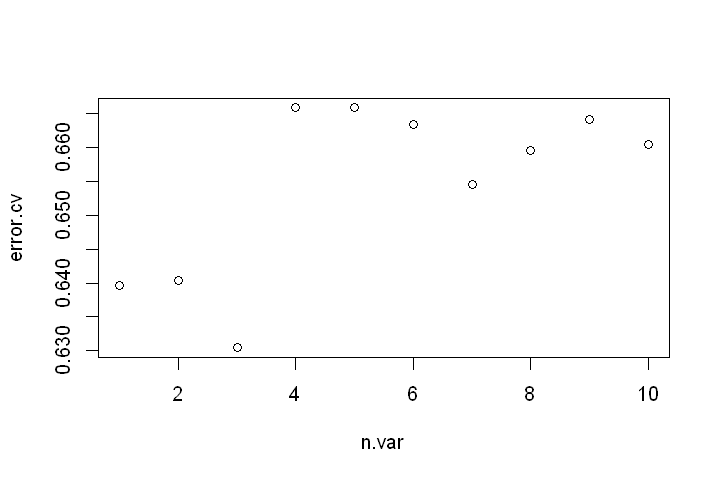

In [90]:
x <- train
x$Result <- NULL
y <- train$Result

rf.cv <- rfcv(x, y, cv.fold=10, step=0.9)

with(rf.cv, plot(n.var, error.cv))

Ok, this is telling us that an 8 feature model is performing the best. Let's try retrain the model without the lowest importance features and rerun the predictions

In [97]:
rforest <- randomForest(Result ~ . - ATT8 - ATT1 - ATT4, data = rforest_train)

In [98]:
rforest


Call:
 randomForest(formula = Result ~ . - ATT8 - ATT1 - ATT4, data = rforest_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 35.85%
Confusion matrix:
    0   1   2   3 class.error
0 356 378 121  18      0.5922
1 349 352 151  21      0.5968
2 113  90 659  11      0.2451
3   0   0   0 873      0.0000

In [99]:
print(importance(rforest,type = 2))

      MeanDecreaseGini
ATT2             367.5
ATT3             341.6
ATT5             341.0
ATT6             353.5
ATT7             365.2
ATT9             364.4
ATT10            364.2


In [100]:
pred <- predict(rforest, test)

In [101]:
confusionMatrix(pred, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 79 97 49 19
         1 91 79 55 18
         2 31 31 24  8
         3  8  9  1  1

Overall Statistics
                                        
               Accuracy : 0.305         
                 95% CI : (0.268, 0.344)
    No Information Rate : 0.36          
    P-Value [Acc > NIR] : 0.998021      
                                        
                  Kappa : -0.027        
 Mcnemar's Test P-Value : 0.000553      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.378    0.366    0.186  0.02174
Specificity             0.578    0.573    0.851  0.96751
Pos Pred Value          0.324    0.325    0.255  0.05263
Neg Pred Value          0.635    0.616    0.792  0.92255
Prevalence              0.348    0.360    0.215  0.07667
Detection Rate          0.132    0.132    0.040  0.00167
Detection Prevalence    0.407    0.405    0.157  0.03167
Balan